In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os

import gsw
#import gsw_xarray as gsw # Wrapper for gsw that adds CF attributes
from wmt_inert_tracer.preprocessing import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

Schmidtko et al. (2014): 
**ASBW** is defined using the deepest measurement in profiles within *30 m* of the bottom, or, in the absence of CTD altimeter data, within 150m of the ETOPO-1 bathymetry. **ASBW** data are mapped onto a 0.25$^{\circ}\times$0.125$^{\circ}$ grid for bathymetry shallower than *1500 m*.

In [2]:
deptho_max = 1500
north = -60.0

In [3]:
outdir='/work/jet/data/interim/'

# Odiv-255
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/'
# Odiv-233, 232, 231, 230
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/'
# Odiv-226, Odiv-210, Odiv-209, Odiv-207, Odiv-206, Odiv-200, Odiv-191, Odiv-184
rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/' # Odiv-183, Odiv-170

#subdir = 'CM4_historical_c192_OM4p125' # odiv-233/odiv-255
#subdir = 'CM4_ssp585_c192_OM4p25' # odiv-232
#subdir = 'CM4_historical_c192_OM4p25' # Odiv-231
#subdir = 'CM4_piControl_c192_OM4p25_v8' # odiv-230
#subdir = 'CM4_piControl_c192_OM4p25_v7_npolefix' # Odiv-226
#subdir = 'CM4_piControl_c192_OM4p25_v7' # Odiv-210
subdir = 'CM4_piControl_c192_OM4p125_v7' # Odiv-209
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt3' # Odiv-207
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt2' # Odiv-206
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt1' # Odiv-200
#subdir = 'CM4_piControl_c192_OM4p125_v6' # Odiv-191
#subdir = 'CM4_piControl_c192_OM4p125_v5' # Odiv-184
#subdir = 'CM4_piControl_c192_OM4p125_v5_proto1' # Odiv-183
#subdir = 'CM4_piControl_c192_OM4p25' # Odiv-170

platform = 'gfdl.ncrc4-intel18-prod-openmp'
#platform = 'gfdl.ncrc5-intel22-prod-openmp' # odiv-255

In [4]:
pp = 'ocean_annual_z'
full_path = os.path.join(rootdir,subdir,platform,'pp',pp)+'/ts/annual/10yr/'

In [5]:
var = 'thetao'
tprd = '*'
print(full_path+pp+'.%s.%s.nc'%(tprd,var))

/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/ocean_annual_z.*.thetao.nc


In [6]:
vars_ds = xr.open_mfdataset(full_path+pp+'.%s.%s.nc'%(tprd,var),use_cftime=True, drop_variables=['average_DT','average_T1','average_T2'])
grid_ds = xr.open_dataset(os.path.join(rootdir,subdir,platform,'pp',pp)+'/'+pp+'.static.nc')

In [7]:
pd.concat([vars_ds.xh.to_series().reset_index(drop=True), #vars_ds.xq.to_series().reset_index(drop=True),
           grid_ds.xh.to_series().reset_index(drop=True), grid_ds.xq.to_series().reset_index(drop=True)], axis=1)

,xh,xh,xq
0,-298.604803,-298.604803,-298.533319
1,-298.488439,-298.488439,-298.417040
2,-298.372071,-298.372071,-298.300755
3,-298.255697,-298.255697,-298.184466
4,-298.139319,-298.139319,-298.068172
...,...,...,...
2876,60.929793,60.929793,61.001614
2877,61.046136,61.046136,61.117873
2878,61.162485,61.162485,61.234138
2879,61.278839,61.278839,61.350407


In [8]:
grid_ds = grid_ds.isel(xq=slice(None,-1),yq=slice(None,-1)) # p125
#grid_ds = grid_ds.isel(xq=slice(1,None),yq=slice(1,None)) # p25

In [9]:
ds = preprocessing(vars_ds, grid_ds, decode_times=False, verbose=False)

In [10]:
teos10 = False

In [11]:
thetaob = ds[var].chunk({'time':1}).ffill('lev').isel(lev=-1).where(ds.lat<north).where(ds.deptho<deptho_max)

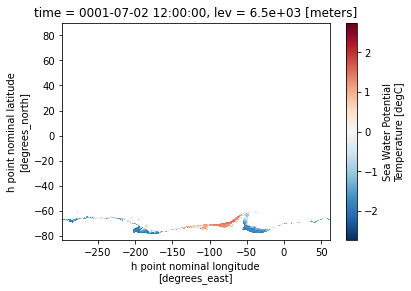

In [12]:
thetaob[0].plot()

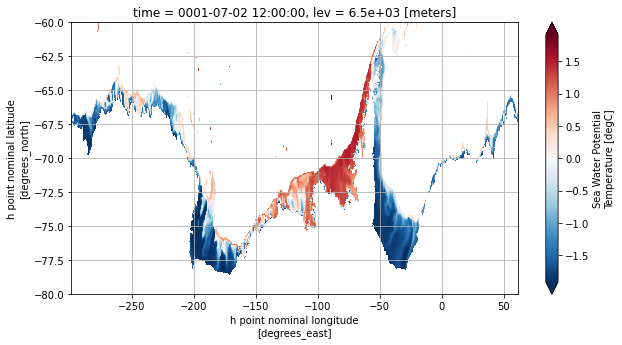

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
thetaob[0].where(ds.wet==1).plot(ax=ax,x='x',y='y',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

In [14]:
#Schmidtko_Antarctic_shelf_data_bottom_salinity_0125, Schmidtko_Antarctic_shelf_data_bottom_salinity_025
sab_obs = xr.open_dataset('/work/jet/Schmidtko_Antarctic_shelf_data_bottom_salinity_0125.nc').bottom_so

In [15]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    thetaob_t0 = thetaob.where(sab_obs.notnull())[0].load()

[########################################] | 100% Completed |  6.1s


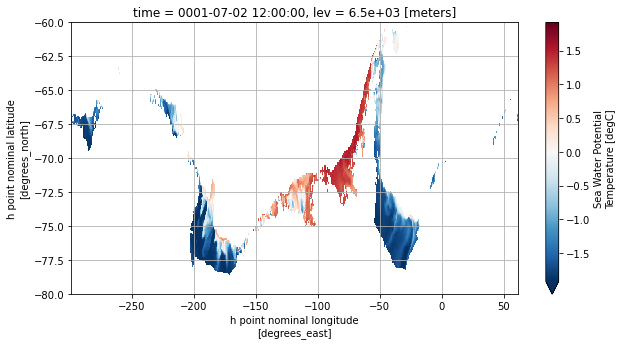

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
thetaob_t0.where(ds.wet==1).plot(ax=ax,x='x',y='y',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

In [17]:
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from compute import horizontal_mean

In [18]:
thetaob.time[-1]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(350, 7, 2, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 0350-07-02 12:00:00
    lev      float64 6.5e+03
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds

In [19]:
with ProgressBar():
    thetaob_so = horizontal_mean(thetaob.where(sab_obs.notnull()),ds).load()

[########################################] | 100% Completed | 19min 51.8s


In [20]:
thetaob_so

<xarray.DataArray (time: 350)>
array([-0.5917735 , -0.6200255 , -0.689329  , -0.73616177, -0.7369279 ,
       -0.73327434, -0.73085374, -0.70102686, -0.689987  , -0.7372294 ,
       -0.7680608 , -0.74901706, -0.7112201 , -0.69851613, -0.6902811 ,
       -0.68599296, -0.6394087 , -0.6595729 , -0.6978913 , -0.6893456 ,
       -0.650465  , -0.6027673 , -0.54820055, -0.50814784, -0.5239447 ,
       -0.5564411 , -0.55459875, -0.60510933, -0.6389657 , -0.63186187,
       -0.6367486 , -0.6096543 , -0.61833054, -0.6684046 , -0.6512799 ,
       -0.6220869 , -0.60183054, -0.5550119 , -0.5628721 , -0.5483294 ,
       -0.6026593 , -0.67656654, -0.68584526, -0.6420142 , -0.6180167 ,
       -0.595233  , -0.58598906, -0.53377426, -0.49317214, -0.46535984,
       -0.45317665, -0.4607363 , -0.45844662, -0.45990264, -0.44570652,
       -0.4488554 , -0.46457222, -0.48361242, -0.49626324, -0.5129005 ,
       -0.5928821 , -0.59899706, -0.6051971 , -0.59241474, -0.61041856,
       -0.60675085, -0.60289353, -0.6420986 , -0.6338401 , -0.6133648 ,
       -0.603824  , -0.63548404, -0.63466156, -0.6475594 , -0.68678945,
       -0.68842626, -0.6969955 , -0.70254815, -0.7194682 , -0.7540762 ,
       -0.80183756, -0.83167094, -0.83055615, -0.8273004 , -0.7869981 ,
       -0.8174055 , -0.8180671 , -0.7802853 , -0.7697018 , -0.7707964 ,
       -0.7604831 , -0.8060819 , -0.8506838 , -0.84951824, -0.87082493,
       -0.8944922 , -0.89380485, -0.89557624, -0.90396756, -0.90314865,
...
       -0.85263044, -0.8028321 , -0.7845271 , -0.7680954 , -0.7703399 ,
       -0.7781403 , -0.77960044, -0.800063  , -0.8039698 , -0.7914062 ,
       -0.8004219 , -0.8093488 , -0.82823926, -0.86935455, -0.8722493 ,
       -0.8702096 , -0.91419595, -0.94747066, -0.94019264, -0.9102327 ,
       -0.89048785, -0.8624191 , -0.84395796, -0.8086388 , -0.7995729 ,
       -0.7795546 , -0.7432781 , -0.7555425 , -0.72607243, -0.7259788 ,
       -0.69817585, -0.7009373 , -0.7279313 , -0.74893796, -0.76237744,
       -0.7705883 , -0.8222662 , -0.81633306, -0.8478299 , -0.86534667,
       -0.84868336, -0.8536889 , -0.8471932 , -0.83177066, -0.82383466,
       -0.8561942 , -0.8465214 , -0.8095032 , -0.8003723 , -0.77885103,
       -0.75916475, -0.7368692 , -0.7454061 , -0.7698861 , -0.8146206 ,
       -0.8685286 , -0.8777386 , -0.87375873, -0.8477058 , -0.82292   ,
       -0.7615929 , -0.75352496, -0.76918924, -0.7938822 , -0.84282374,
       -0.8148341 , -0.76894355, -0.7753411 , -0.77436054, -0.78409696,
       -0.7780647 , -0.7400839 , -0.73494864, -0.7333829 , -0.7522806 ,
       -0.7972346 , -0.79645133, -0.7842447 , -0.8068552 , -0.8263482 ,
       -0.8058403 , -0.78983694, -0.78087837, -0.7843503 , -0.7821531 ,
       -0.78136826, -0.7617898 , -0.7614488 , -0.7711703 , -0.77411896,
       -0.7724487 , -0.79470944, -0.84624153, -0.86709815, -0.87238175],
      dtype=float32)
Coordinates:
  * time     (time) object 0001-07-02 12:00:00 ... 0350-07-02 12:00:00
    lev      float64 6.5e+03

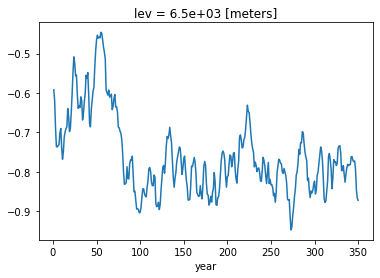

In [21]:
thetaob_so.groupby('time.year').mean('time').plot()

In [22]:
fname = subdir+'_%sto%s_thetaob_onshlf.nc'%(str(thetaob_so.time.dt.year[0].values).rjust(4, '0'),
                                            str(thetaob_so.time.dt.year[-1].values).rjust(4, '0'))
print('Saving to file:', fname)
thetaob_so.reset_coords(drop=True).to_dataset(name='bottom_thetao').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v7_0001to0350_thetaob_onshlf.nc
